In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

np.random.seed(1234)
mkl.set_num_threads(4)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Utility functions

In [13]:
def append_ones(matrix, axis=1):
    ones = np.ones((matrix.shape[0], 1), dtype=matrix.dtype)
    return np.concatenate((matrix, ones), axis=axis)

## Feed-forward, activations and tiles

In [14]:
# one layer feed forward
def feed_forward(W, dataset, activation_fun):
    W = W[:, :-1]
    return activation_fun(np.dot(dataset, W))

In [15]:
# sigmoid activation function
def sigmoid(matrix):
    activations = 1/(1 + np.exp(-matrix))
    return activations
    

In [16]:
# arrange 2D matrices as tiles (takes 4D `examples` tensor with dims: rows x cols x tile_height x tile_width)
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    width_offset = tile_width + space_between_tiles
    height_offset = tile_height + space_between_tiles
    
    img_matrix = np.zeros((width_offset * rows_count - space_between_tiles, 
                           height_offset * cols_count - space_between_tiles), dtype=np.float32)
    
    img_matrix.fill(np.nan)
    
    for r in range(0, rows_count):
        for c in range(0, cols_count):
            r_coord = r * width_offset
            c_coord = c * height_offset
            img_matrix[r_coord:r_coord + tile_height, c_coord:c_coord + tile_width] = examples[r, c]

    return img_matrix


## Histogram of activations and filters plot

In [17]:
class Rbm:
    def __init__(self, visible_size, hidden_size, learning_rate):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.W = np.random.normal(scale=0.01, size=(visible_size+1, hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0

In [21]:
import mnist
import pickle
import seaborn as sns

with open("./lab1_rbm.pickle.dat", "rb") as f:
    rbm = pickle.load(f)

DATASET_SIZE = 512
DIGIT_SIZE = 28
mnist_dataset = mnist.test_images().astype(np.float32)
np.random.shuffle(mnist_dataset)
mnist_dataset = np.reshape(mnist_dataset[:DATASET_SIZE] / 255.0, newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))

mnist_dataset = append_ones(mnist_dataset)

C:\Users\mikol\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


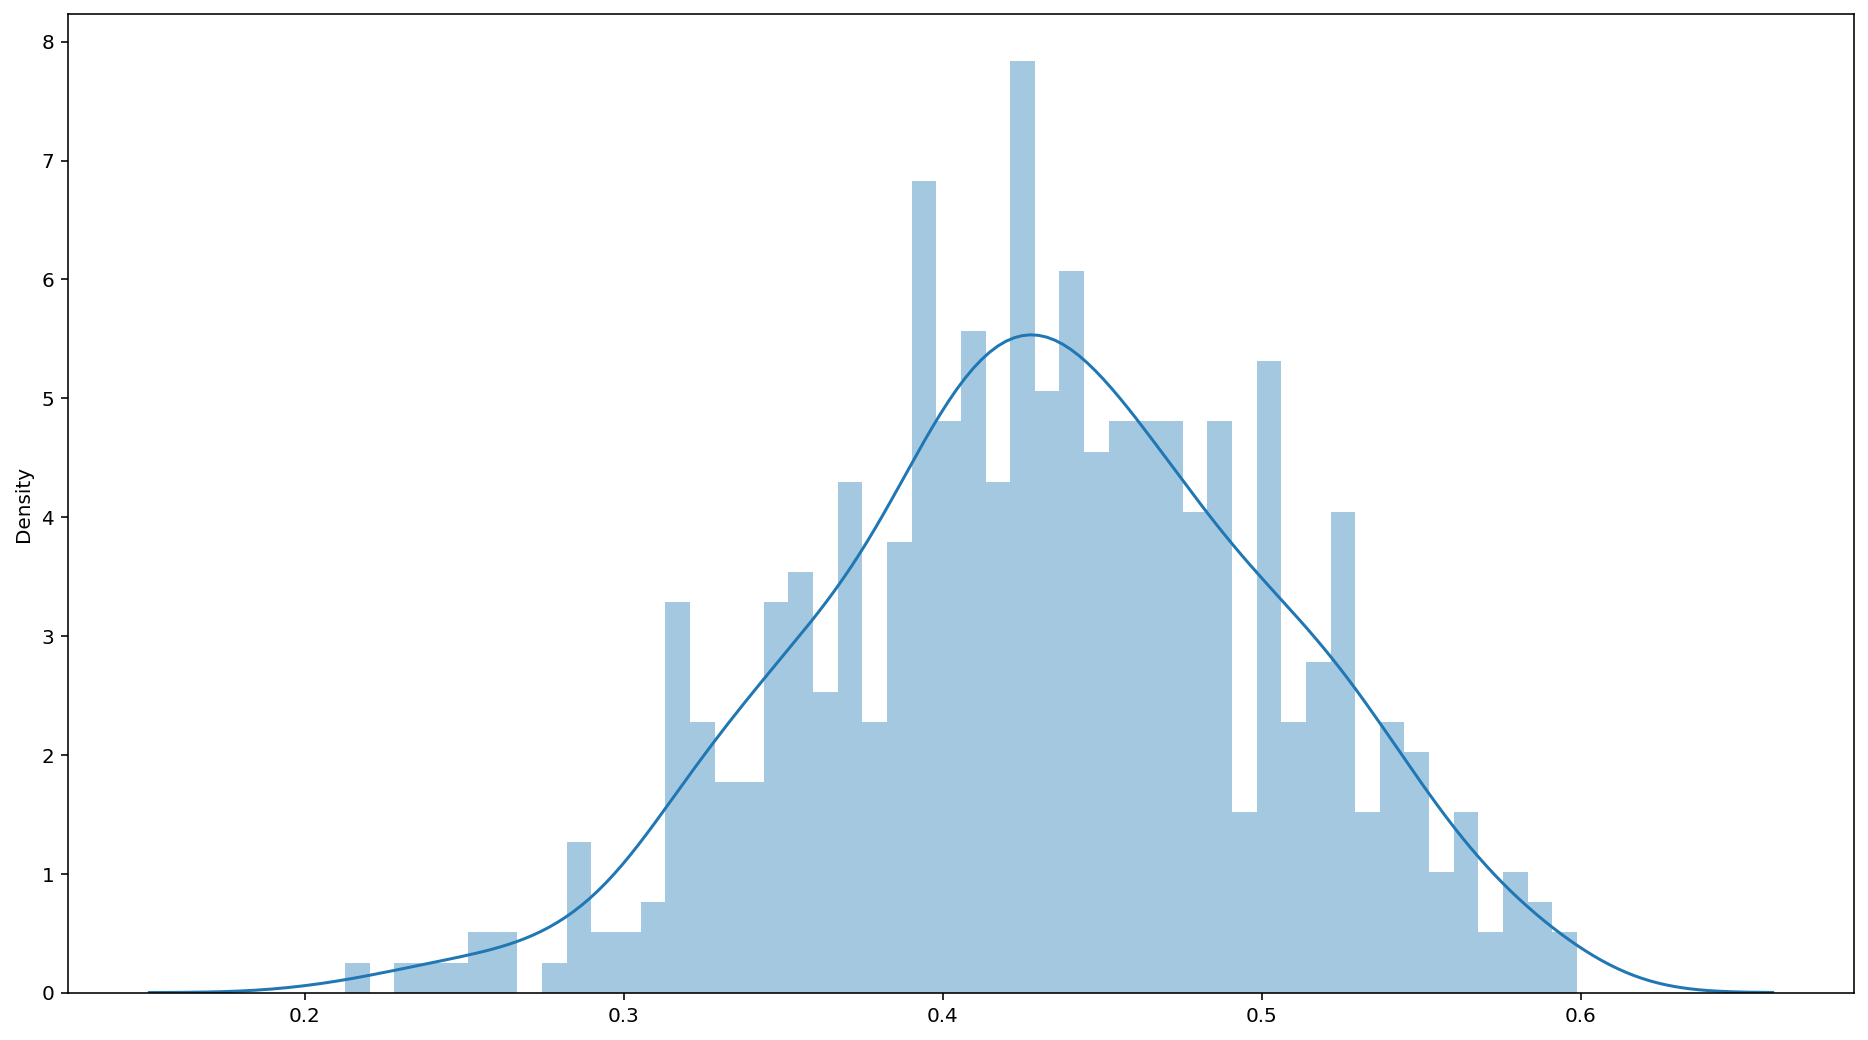

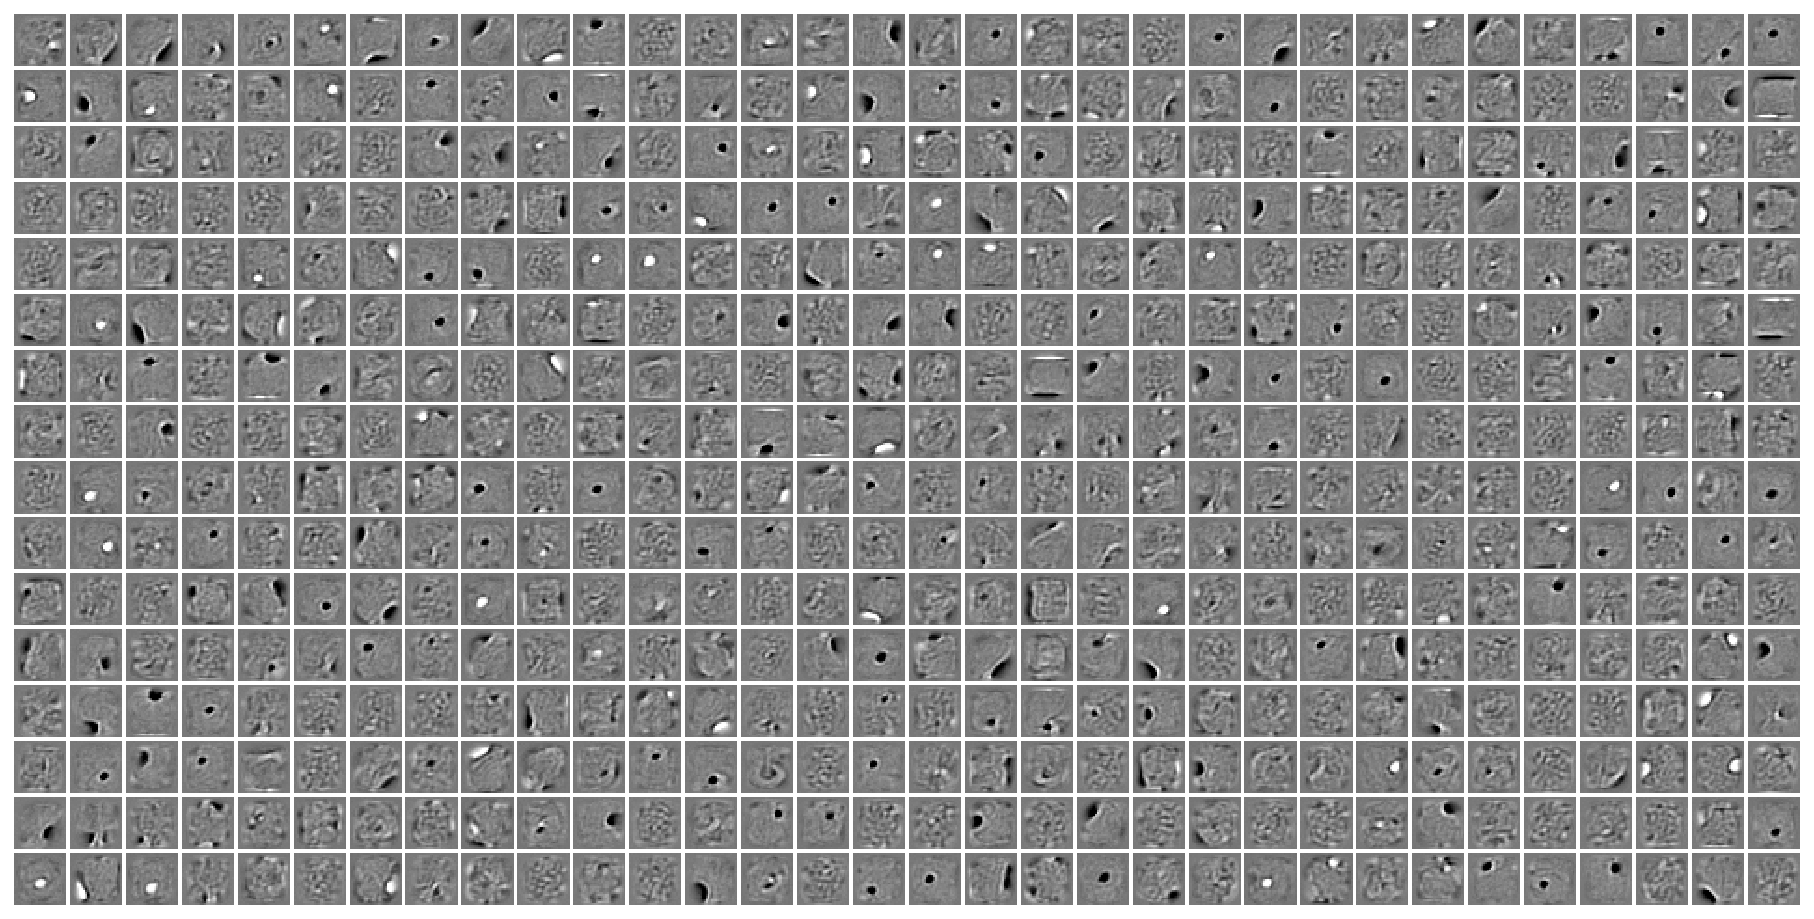

In [22]:
# Plotting mean hidden activations
activations = feed_forward(rbm.W, mnist_dataset, sigmoid)
mean_activations = np.mean(activations, 1)
sns.distplot(mean_activations, bins=50)

# Displaying RBM filetrs
filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(16, -1, 28, 28))
filters = np.clip(filters, -1.0, 1.0)

img = tiles(filters)
plt.matshow(img, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()